# Autoencoder Anomaly Detection
Prototype an anomaly detection algorithm using autoencoders. Will be using fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [24]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import tensorboard

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import shuffle

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [2]:
# class for data prep
class DataPrep:
    def __init__(self, keras_dataset, class_normal, random_int=16, print_shapes=False):
        
        self.class_normal = class_normal
        self.random_int = random_int
        self.print_shapes = print_shapes

        (X_train_all, y_train_all), (X_test, y_test) = keras_dataset.load_data()

        # shuffle the data, as a precaution
        self.X_train_all, self.y_train_all = shuffle(X_train_all, y_train_all, random_state=random_int)
        self.X_test, self.y_test = shuffle(X_test, y_test, random_state=random_int)

        # convert all to dtype float32
        self.X_train_all = self.X_train_all.astype('float32')
        self.X_test = self.X_test.astype('float32')

    def remove_classes(self, X_val_slim, y_val_slim):
        """Funciton to remove classes from train/val set"""
        
        class_to_remove = [i for i in range(0,10)]
        class_to_remove.remove(self.class_normal)
        class_to_remove = np.array(class_to_remove,dtype='uint8')

        # start with y_valid_slim
        index_to_delete = []
        for i, class_digit in enumerate(y_val_slim):
            if class_digit in class_to_remove:
                index_to_delete.append(i)

        y_val_slim = np.delete(y_val_slim, index_to_delete)
        X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)

        return X_val_slim, y_val_slim
        
    def train_test_split(self):
        # split the data between train and validation sets, and scale
        # also have a "slimmed down" data set that has only positive classes that will be used to train the autoencoder
        self.X_val, self.X_val_slim, self.X_train = self.X_train_all[:5000] / 255.0, \
                                                self.X_train_all[5000:10000] / 255.0, \
                                                self.X_train_all[10000:] / 255.0
        self.y_val, self.y_val_slim, self.y_train = self.y_train_all[:5000],self.y_train_all[5000:10000], self.y_train_all[10000:]

        # also scale the X_test
        self.X_test = self.X_test / 255.0
        
        self.X_train_slim, self.y_train_slim = self.remove_classes(self.X_train, self.y_train)
        self.X_val_slim, self.y_val_slim = self.remove_classes(self.X_val_slim, self.y_val_slim)
        
        if self.print_shapes == True:
            print('X_val shape:', self.X_val.shape)
            print('y_val shape:', self.y_val.shape)
            print('X_val_slim shape:', self.X_val_slim.shape)
            print('y_val_slim shape:', self.y_val_slim.shape)
            print('X_train shape:', self.X_train.shape)
            print('y_train shape:', self.y_train.shape)
            print('X_train_slim shape:', self.X_train_slim.shape)
            print('y_train_slim shape:', self.y_train_slim.shape)
        
        return (self.X_train, 
                self.y_train, 
                self.X_train_slim, 
                self.y_train_slim, 
                self.X_val,
                self.y_val,
                self.X_val_slim,
                self.y_val_slim,
                self.X_test,
                self.y_test)


In [3]:
class_normal = 6

# class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fashion_mnist = keras.datasets.fashion_mnist
data_model = DataPrep(fashion_mnist,class_normal)

(X_train, y_train, 
 X_train_slim, y_train_slim,
 X_val, y_val,
 X_val_slim, y_val_slim,
 X_test,y_test) = data_model.train_test_split()

## 2.0 Sparse Autoencoder

We will build as sparse autoencoder. But first, we will build a vanilla stacked autoencoder as a comparison.

Andrew Ng has a good video of what a sparse autoencoder is: https://youtu.be/vfnxKO2rMq4

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Note: we are using sigmoid activations so that the activations all end up between 0 and 1. This will make visualizing the activations easier.

In [5]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

We want to see how the activations behave with this simple stacked autoencoder.
- Using the validation data set, **what is the distribution of activations between 0 and 1?**
- Using the validation data set, **what are the average neuron activation values?**

In [6]:
# build custom regularizer for KL-Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
def sparse_kl_model(X_train_slim, X_val_slim, seed=42, epochs=500, earlystop_patience=8):

    tf.random.set_seed(seed)
    np.random.seed(seed)

    kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
    sparse_kl_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
    ])
    sparse_kl_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[300]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ])
    sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
    sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),
                  metrics=[rounded_accuracy])

    # show summary, if wanted
    # sparse_kl_encoder.summary()
    # sparse_kl_decoder.summary()

    # use tensorboard to track training
    log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                          histogram_freq=0,
                                                          update_freq='epoch',
                                                          profile_batch=0)

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=8, 
                                                          restore_best_weights=True)

    history = sparse_kl_ae.fit(X_train_slim, X_train_slim, epochs=epochs,
                               validation_data=[X_val_slim, X_val_slim], 
                               callbacks=[tensorboard_callback,earlystop_callback],verbose=0)
    return sparse_kl_ae

In [8]:
sparse_kl_ae = sparse_kl_model(X_train_slim, X_val_slim, seed=42, epochs=500)

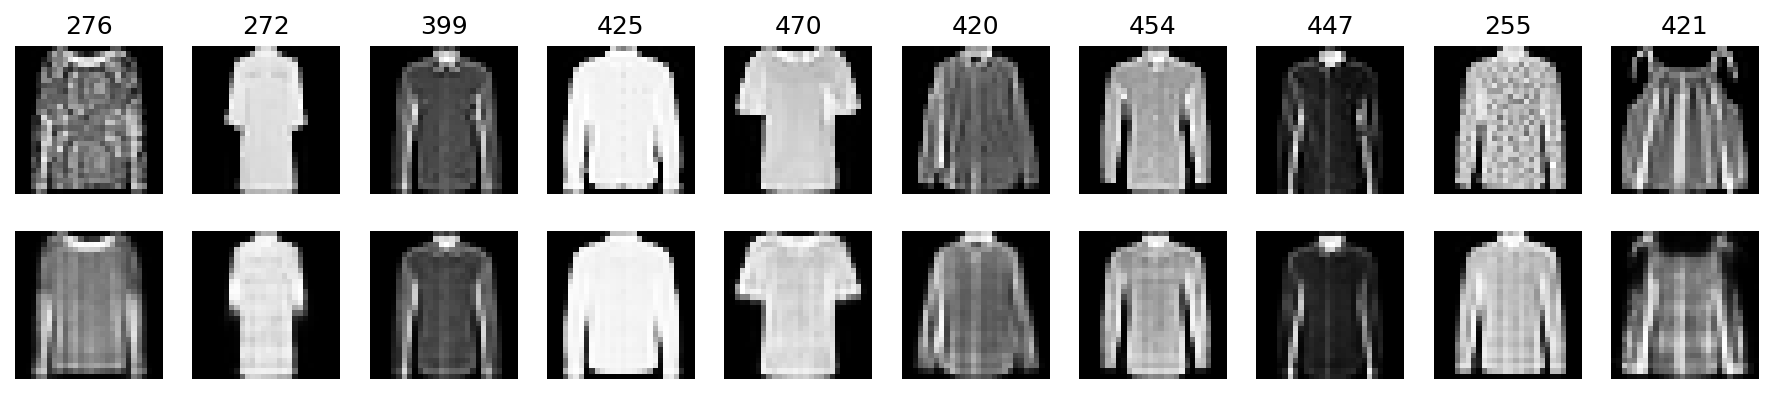

In [9]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_val_slim)), 10)

plot_reconstructions(sparse_kl_ae, index_list, X_val_slim)

In [11]:
class SelectThreshold:
    
    def __init__(self, model, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names):
        
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.X_val_slim = X_val_slim
        self.class_to_remove = class_to_remove
        self.class_normal = class_normal
        self.class_names = class_names
        
        print(np.shape(self.X_val))
        
        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        self.recon_val_slim = self.model(self.X_val_slim).numpy()
        self.recon_val = self.model(self.X_val).numpy()
        
    def mse(self, X_val, recon_val):
        """Calculate MSE for images in X_val and recon_val"""
        # need to calculate mean across the rows, and then across the columns
        return np.mean(np.mean(np.square(X_val - recon_val),axis=1),axis=1)

    def rmse(self, X_val, recon_val):
        """Calculate RMSE for images in X_val and recon_val"""
        return np.sqrt(self.mse(X_val, recon_val))

    def euclidean_distance(self, X_val, recon_val):
        dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
        return dist
    
    # function that creates a pandas dataframe with the RMSE value, and the associated class
    def create_df_reconstruction(self, reconstruction_error_val, threshold_val):
        df = pd.DataFrame(data=reconstruction_error_val, columns=["metric"])

        class_names_list = list(zip(self.class_names, range(len(self.class_names))))
        
        y_names = []
        for i in self.y_val:
            y_names.append(str(i)+", "+class_names_list[i][0])
        
        # append the class values
        df['class'] = self.y_val
        df['class_names'] = y_names

        # label anomolous (outlier) data as -1, inliers as 1
            # -1 (outlier) is POSITIVE class
            #  1 (inlier) is NEGATIVE class
        new_y_val = []
        for i in self.y_val:
            if i in class_to_remove:
                new_y_val.append(-1)
            else:
                new_y_val.append(1)

        df['true_class'] = new_y_val

        # add prediction based on threshold
        df['prediction'] = np.where(df['metric'] >= threshold_val,-1,1)

        return df
    
    def threshold_grid_search(self, lower_bound, upper_bound, reconstruction_error_val, grid_iterations=10):
        '''Simple grid search for finding the best threshold'''
    
        roc_scores = {}
        grid_search_count = 0
        for i in np.arange(lower_bound, upper_bound, (np.abs(upper_bound-lower_bound) / grid_iterations)):
#             if grid_search_count%50 == 0:
#                 print('grid search iteration: ', grid_search_count)

            threshold_val = i
            df = self.create_df_reconstruction(reconstruction_error_val, 
                                          threshold_val)
            roc_val = roc_auc_score(df['true_class'], df['prediction'])
            roc_scores[i] = roc_val
            grid_search_count += 1

        # return best roc_score and the threshold used to set it
        threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
        best_threshold = threshold_val[1]
        best_roc_score = threshold_val[0]
        print('Best threshold value:', best_threshold,'\tROC score: {:.2%}'.format(best_roc_score))

        # use the best threshold value to make a confusion matrix
        df = self.create_df_reconstruction(reconstruction_error_val, best_threshold)
        
        return df, best_threshold, best_roc_score
    
    def box_plot(self, df, best_threshold, best_roc_score, metric):
        fig, ax = plt.subplots(figsize=(12,5))
        df.boxplot(column=['metric'], by='class_names', ax=ax).axhline(y=best_threshold,c='red',alpha=0.7)
        plt.title('Boxplots of {} for X_valid, by Class'.format(metric))
        plt.suptitle('')
        plt.show()
        
        print('\nConfusion Matrix:')
        print(confusion_matrix(df['true_class'], df['prediction']))
        
    # function to test the different reconstruction methods (mse, rmse, euclidean)
    # do a grid search looking for the best threshold, and then outputting the results
    def compare_error_method(self,show_results=True, grid_iterations=10):
        '''Function to test the different reconstruction methods (mse, rmse, euclidean) 

        Parameters
        ===========
        model : tensorflow model
            autoencoder model that was trained on the "slim" data set.
            Will be used to build reconstructions

        X_val : ndarray
            tensor of the X validation set

        class_to_remove : ndarray
            numpy array of the classes to remove from the X_val and y_val data
        '''
        
        col = ['class_normal','method','best_threshold','best_roc_score']
        result_table = pd.DataFrame(columns=col)
        
        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        recon_val_slim = self.model(self.X_val_slim).numpy()
        recon_val = self.model(self.X_val).numpy()

        # run through each of the reconstruction error methods, perform a little grid search
        # to find the optimum value

        #_______MSE_______#
        # calculate MSE reconstruction error
        mse_recon_val_slim = self.mse(self.X_val_slim, recon_val_slim) # for slim dataset
        mse_recon_val = self.mse(self.X_val, recon_val) # for complete validation dataset
        
        max_mse = np.max(mse_recon_val_slim)
        percentile_mse = np.percentile(mse_recon_val_slim,90)

        lower_bound = percentile_mse - percentile_mse*0.9
        upper_bound = max_mse*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                                upper_bound,
                                                                                mse_recon_val,grid_iterations)
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'mse',
                                                          best_threshold, 
                                                          best_roc_score]],
                                                        columns=col))
        
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'MSE')
        
        #_______RMSE_______#
        # calculate RMSE reconstruction error
        rmse_recon_val_slim = self.rmse(self.X_val_slim, recon_val_slim) # for slim dataset
        rmse_recon_val = self.rmse(self.X_val, recon_val) # for complete validation dataset
        
        max_rmse = np.max(rmse_recon_val_slim)
        percentile_rmse = np.percentile(rmse_recon_val_slim,90)

        lower_bound = percentile_rmse - percentile_rmse*0.9
        upper_bound = max_rmse*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                                upper_bound,
                                                                                rmse_recon_val,grid_iterations)
        
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'rmse',
                                                  best_threshold, 
                                                  best_roc_score]],
                                                columns=col))
        
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'RMSE')
        
        #_______Euclidean_______#
        # calculate Euclidean reconstruction error
        eu_recon_val_slim = self.euclidean_distance(self.X_val_slim, recon_val_slim) # for slim dataset
        eu_recon_val = self.euclidean_distance(self.X_val, recon_val) # for complete validation dataset
        
        max_eu = np.max(eu_recon_val_slim)
        percentile_eu = np.percentile(eu_recon_val_slim,90)

        lower_bound = percentile_eu - percentile_eu*0.9
        upper_bound = max_eu*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                      upper_bound, 
                                                                      eu_recon_val,grid_iterations)
        
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'euclid_dist',
                                          best_threshold, 
                                          best_roc_score]],
                                        columns=col))
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'Euclidean Distance')
        
        return result_table

In [12]:
class_to_remove = [i for i in range(0,10)]
class_to_remove.remove(class_normal)
class_to_remove = np.array(class_to_remove,dtype='uint8')

model = SelectThreshold(sparse_kl_ae, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names)
# model = SelectThreshold(sparse_kl_ae, X_train, y_train, X_train_slim, class_to_remove, class_normal, class_names)

(5000, 28, 28)


Best threshold value: 0.006709839936811476 	ROC score: 71.00%


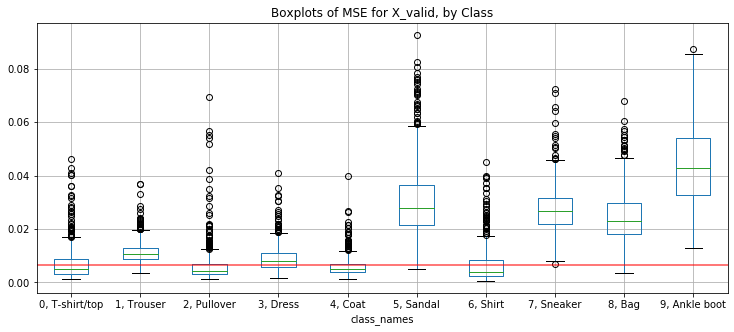


Confusion Matrix:
[[3251 1260]
 [ 147  342]]
Best threshold value: 0.07232051384821533 	ROC score: 71.25%


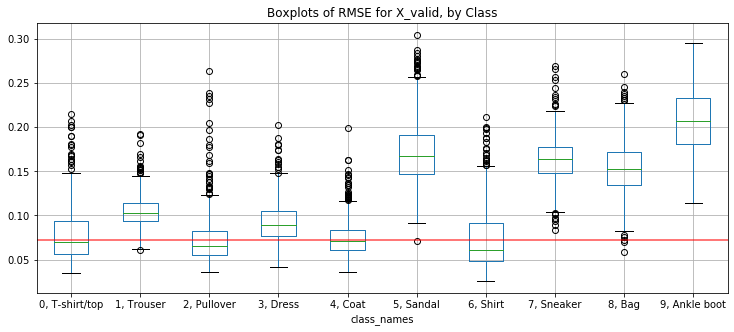


Confusion Matrix:
[[3559  952]
 [ 178  311]]
Best threshold value: 2.0249742894768716 	ROC score: 71.25%


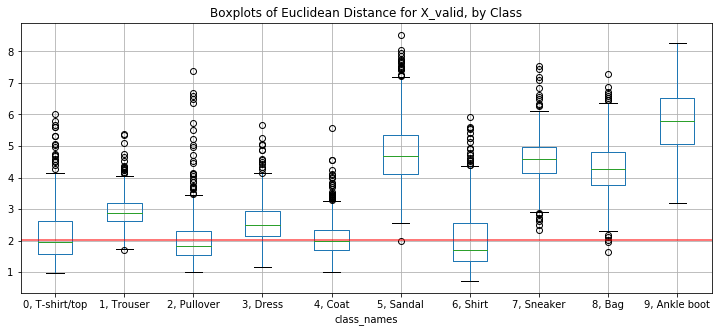


Confusion Matrix:
[[3559  952]
 [ 178  311]]


In [13]:
df = model.compare_error_method(show_results=True, grid_iterations=200)

There is problem detecting anomalies when the "noraml" class is a shirt. I think this is because the shirt is very similar to many of the other clothing types.

## 3.0 Test Multiple Classes

In [28]:
import random
random.randint(0,250)

74

In [90]:
col = ['class_normal','method','best_threshold','best_roc_score']
df_all = pd.DataFrame(columns=col)
fashion_mnist = keras.datasets.fashion_mnist
run_no = 1
for class_normal in range(0,10):
    for i in range(0,50):
        print('Run no: ', run_no, ' Class: ', class_normal)
        # load data

        # class names
        class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                       "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
        
        random_int = random.randint(0,500)
        print('Random seed: ',random_int)
        
        data_model = DataPrep(fashion_mnist,class_normal, random_int=random_int)

        (X_train, y_train, 
         X_train_slim, y_train_slim,
         X_val, y_val,
         X_val_slim, y_val_slim,
         X_test,y_test) = data_model.train_test_split()

        sparse_kl_ae = sparse_kl_model(X_train_slim, X_val_slim, seed=random_int, epochs=500, earlystop_patience=8)

        class_to_remove = [i for i in range(0,10)]
        class_to_remove.remove(class_normal)
        class_to_remove = np.array(class_to_remove,dtype='uint8')

        model = SelectThreshold(sparse_kl_ae, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names)
        df = model.compare_error_method(show_results=False, grid_iterations=200)

        df_all = df_all.append(df)
        
        run_no += 1

Run no:  1  Class:  0
Random seed:  71
(5000, 28, 28)
Best threshold value: 0.0065968783884309224 	ROC score: 84.09%
Best threshold value: 0.08177399586886165 	ROC score: 84.14%
Best threshold value: 2.289671823978425 	ROC score: 84.14%
Run no:  2  Class:  0
Random seed:  184
(5000, 28, 28)
Best threshold value: 0.013608068773895506 	ROC score: 83.13%
Best threshold value: 0.11752103378176687 	ROC score: 83.27%
Best threshold value: 3.2905889932632455 	ROC score: 83.27%
Run no:  3  Class:  0
Random seed:  107
(5000, 28, 28)
Best threshold value: 0.011503378015011547 	ROC score: 83.46%
Best threshold value: 0.10643526479601857 	ROC score: 83.62%
Best threshold value: 2.9801875090599053 	ROC score: 83.62%
Run no:  4  Class:  0
Random seed:  178
(5000, 28, 28)
Best threshold value: 0.006547336642909795 	ROC score: 83.03%
Best threshold value: 0.0808097416341305 	ROC score: 82.95%
Best threshold value: 2.262672771644592 	ROC score: 82.95%
Run no:  5  Class:  0
Random seed:  238
(5000, 28, 

(5000, 28, 28)
Best threshold value: 0.007170447245892141 	ROC score: 82.27%
Best threshold value: 0.08231959101408724 	ROC score: 82.29%
Best threshold value: 2.304948588538169 	ROC score: 82.29%
Run no:  23  Class:  0
Random seed:  183
(5000, 28, 28)
Best threshold value: 0.006450080641172824 	ROC score: 81.90%
Best threshold value: 0.08079886183887718 	ROC score: 81.89%
Best threshold value: 2.2623681017875654 	ROC score: 81.89%
Run no:  24  Class:  0
Random seed:  499
(5000, 28, 28)
Best threshold value: 0.010627128334715965 	ROC score: 82.23%
Best threshold value: 0.10353172723948954 	ROC score: 82.27%
Best threshold value: 2.898888235092163 	ROC score: 82.27%
Run no:  25  Class:  0
Random seed:  338
(5000, 28, 28)
Best threshold value: 0.008460520869120955 	ROC score: 82.50%
Best threshold value: 0.0846957996748388 	ROC score: 82.73%
Best threshold value: 2.371482420444489 	ROC score: 82.73%
Run no:  26  Class:  0
Random seed:  358
(5000, 28, 28)
Best threshold value: 0.006935443

Best threshold value: 2.3147234014034264 	ROC score: 80.63%
Run no:  44  Class:  0
Random seed:  28
(5000, 28, 28)
Best threshold value: 0.007250985039398073 	ROC score: 82.09%
Best threshold value: 0.08658506970480084 	ROC score: 82.13%
Best threshold value: 2.4243819447159765 	ROC score: 82.13%
Run no:  45  Class:  0
Random seed:  416
(5000, 28, 28)
Best threshold value: 0.006603285804390907 	ROC score: 82.46%
Best threshold value: 0.08187911414168769 	ROC score: 82.52%
Best threshold value: 2.2926152327537532 	ROC score: 82.52%
Run no:  46  Class:  0
Random seed:  383
(5000, 28, 28)
Best threshold value: 0.009229910588404165 	ROC score: 84.61%
Best threshold value: 0.0950233641862869 	ROC score: 84.63%
Best threshold value: 2.6606543483734124 	ROC score: 84.63%
Run no:  47  Class:  0
Random seed:  475
(5000, 28, 28)
Best threshold value: 0.00698737267954275 	ROC score: 83.41%
Best threshold value: 0.07975064485967155 	ROC score: 83.34%
Best threshold value: 2.233017968559266 	ROC sc

(5000, 28, 28)
Best threshold value: 0.006446327674109489 	ROC score: 94.98%
Best threshold value: 0.07966472158133982 	ROC score: 95.00%
Best threshold value: 2.2306121412456035 	ROC score: 95.00%
Run no:  66  Class:  1
Random seed:  5
(5000, 28, 28)
Best threshold value: 0.005616674297675491 	ROC score: 95.01%
Best threshold value: 0.0751325228046626 	ROC score: 95.00%
Best threshold value: 2.1037106119990345 	ROC score: 95.00%
Run no:  67  Class:  1
Random seed:  176
(5000, 28, 28)
Best threshold value: 0.005748749692575075 	ROC score: 95.59%
Best threshold value: 0.07742186947539448 	ROC score: 95.63%
Best threshold value: 2.1678125112533575 	ROC score: 95.63%
Run no:  68  Class:  1
Random seed:  487
(5000, 28, 28)
Best threshold value: 0.008809605295769869 	ROC score: 95.76%
Best threshold value: 0.09366499174199998 	ROC score: 95.78%
Best threshold value: 2.6226198301792145 	ROC score: 95.78%
Run no:  69  Class:  1
Random seed:  317
(5000, 28, 28)
Best threshold value: 0.00658006

(5000, 28, 28)
Best threshold value: 0.007278268046188167 	ROC score: 95.94%
Best threshold value: 0.08494213772863149 	ROC score: 95.96%
Best threshold value: 2.3783798903703683 	ROC score: 95.96%
Run no:  87  Class:  1
Random seed:  268
(5000, 28, 28)
Best threshold value: 0.007359533485257999 	ROC score: 95.89%
Best threshold value: 0.08386716950684786 	ROC score: 95.91%
Best threshold value: 2.3482809379100797 	ROC score: 95.91%
Run no:  88  Class:  1
Random seed:  2
(5000, 28, 28)
Best threshold value: 0.01086860597860068 	ROC score: 95.21%
Best threshold value: 0.10371043346151708 	ROC score: 95.26%
Best threshold value: 2.9038921586751925 	ROC score: 95.26%
Run no:  89  Class:  1
Random seed:  370
(5000, 28, 28)
Best threshold value: 0.005958965757768601 	ROC score: 95.87%
Best threshold value: 0.07659965381920338 	ROC score: 95.90%
Best threshold value: 2.144790416550636 	ROC score: 95.90%
Run no:  90  Class:  1
Random seed:  469
(5000, 28, 28)
Best threshold value: 0.007748380

Best threshold value: 0.08201576291918757 	ROC score: 79.53%
Best threshold value: 2.296441365814209 	ROC score: 79.53%
Run no:  108  Class:  2
Random seed:  441
(5000, 28, 28)
Best threshold value: 0.006859908589627593 	ROC score: 78.31%
Best threshold value: 0.08413200777731836 	ROC score: 78.32%
Best threshold value: 2.355696246111394 	ROC score: 78.32%
Run no:  109  Class:  2
Random seed:  458
(5000, 28, 28)
Best threshold value: 0.006469178301282226 	ROC score: 80.76%
Best threshold value: 0.07926042101159692 	ROC score: 80.68%
Best threshold value: 2.219291617012023 	ROC score: 80.68%
Run no:  110  Class:  2
Random seed:  153
(5000, 28, 28)
Best threshold value: 0.005618620950495823 	ROC score: 80.72%
Best threshold value: 0.0742661661464721 	ROC score: 80.49%
Best threshold value: 2.079452677142621 	ROC score: 80.49%
Run no:  111  Class:  2
Random seed:  490
(5000, 28, 28)
Best threshold value: 0.013037851971387862 	ROC score: 82.19%
Best threshold value: 0.1146737499367446 	ROC

Best threshold value: 2.2159252130985245 	ROC score: 80.40%
Run no:  129  Class:  2
Random seed:  117
(5000, 28, 28)
Best threshold value: 0.007231003420427443 	ROC score: 79.55%
Best threshold value: 0.08485304254293442 	ROC score: 79.62%
Best threshold value: 2.375885139584542 	ROC score: 79.62%
Run no:  130  Class:  2
Random seed:  82
(5000, 28, 28)
Best threshold value: 0.007105546747520565 	ROC score: 80.95%
Best threshold value: 0.08422903843708338 	ROC score: 80.95%
Best threshold value: 2.358413123822212 	ROC score: 80.95%
Run no:  131  Class:  2
Random seed:  139
(5000, 28, 28)
Best threshold value: 0.0067903387248516075 	ROC score: 79.92%
Best threshold value: 0.08468309596180916 	ROC score: 80.00%
Best threshold value: 2.3711268444061266 	ROC score: 80.00%
Run no:  132  Class:  2
Random seed:  322
(5000, 28, 28)
Best threshold value: 0.006623569072876126 	ROC score: 81.74%
Best threshold value: 0.0801018777888268 	ROC score: 81.80%
Best threshold value: 2.2428525641441355 	R

(5000, 28, 28)
Best threshold value: 0.0070044408121611905 	ROC score: 79.16%
Best threshold value: 0.08450197836756708 	ROC score: 79.07%
Best threshold value: 2.366055537700653 	ROC score: 79.07%
Run no:  151  Class:  3
Random seed:  121
(5000, 28, 28)
Best threshold value: 0.009791606432385741 	ROC score: 84.44%
Best threshold value: 0.09668064014911655 	ROC score: 84.45%
Best threshold value: 2.7070581550598134 	ROC score: 84.45%
Run no:  152  Class:  3
Random seed:  230
(5000, 28, 28)
Best threshold value: 0.0069574030465446406 	ROC score: 82.57%
Best threshold value: 0.08388499360084534 	ROC score: 82.65%
Best threshold value: 2.348779919338226 	ROC score: 82.65%
Run no:  153  Class:  3
Random seed:  405
(5000, 28, 28)
Best threshold value: 0.0062041172128170724 	ROC score: 84.28%
Best threshold value: 0.08033335196971891 	ROC score: 84.19%
Best threshold value: 2.2493338832855225 	ROC score: 84.19%
Run no:  154  Class:  3
Random seed:  11
(5000, 28, 28)
Best threshold value: 0.0

(5000, 28, 28)
Best threshold value: 0.008875932272523642 	ROC score: 83.74%
Best threshold value: 0.09452806688100102 	ROC score: 83.99%
Best threshold value: 2.646785855948925 	ROC score: 83.99%
Run no:  172  Class:  3
Random seed:  90
(5000, 28, 28)
Best threshold value: 0.009366640504449608 	ROC score: 83.03%
Best threshold value: 0.09314473688602448 	ROC score: 83.03%
Best threshold value: 2.608052764892578 	ROC score: 83.03%
Run no:  173  Class:  3
Random seed:  486
(5000, 28, 28)
Best threshold value: 0.006831904198229313 	ROC score: 83.23%
Best threshold value: 0.08266263322979213 	ROC score: 83.23%
Best threshold value: 2.3145537234306333 	ROC score: 83.23%
Run no:  174  Class:  3
Random seed:  488
(5000, 28, 28)
Best threshold value: 0.006344882358331232 	ROC score: 82.51%
Best threshold value: 0.07851861178874966 	ROC score: 82.47%
Best threshold value: 2.198521251678467 	ROC score: 82.47%
Run no:  175  Class:  3
Random seed:  177
(5000, 28, 28)
Best threshold value: 0.00807

Best threshold value: 0.07513009113073353 	ROC score: 83.55%
Best threshold value: 2.1036423969268814 	ROC score: 83.55%
Run no:  193  Class:  3
Random seed:  287
(5000, 28, 28)
Best threshold value: 0.006137796762585638 	ROC score: 84.85%
Best threshold value: 0.07916215754002333 	ROC score: 84.73%
Best threshold value: 2.2165402960777287 	ROC score: 84.73%
Run no:  194  Class:  3
Random seed:  199
(5000, 28, 28)
Best threshold value: 0.007359267136454583 	ROC score: 84.73%
Best threshold value: 0.08582319317758083 	ROC score: 84.82%
Best threshold value: 2.4030492975115774 	ROC score: 84.82%
Run no:  195  Class:  3
Random seed:  44
(5000, 28, 28)
Best threshold value: 0.007374117459356785 	ROC score: 85.01%
Best threshold value: 0.08727650355696678 	ROC score: 85.02%
Best threshold value: 2.4437420314788825 	ROC score: 85.02%
Run no:  196  Class:  3
Random seed:  337
(5000, 28, 28)
Best threshold value: 0.008846572970505801 	ROC score: 83.19%
Best threshold value: 0.080318999645859 	

Best threshold value: 2.180143003845215 	ROC score: 83.44%
Run no:  214  Class:  4
Random seed:  231
(5000, 28, 28)
Best threshold value: 0.006782825128547847 	ROC score: 81.76%
Best threshold value: 0.08176408487558368 	ROC score: 81.65%
Best threshold value: 2.289394359588624 	ROC score: 81.65%
Run no:  215  Class:  4
Random seed:  58
(5000, 28, 28)
Best threshold value: 0.005942419970361517 	ROC score: 81.53%
Best threshold value: 0.07839180618152022 	ROC score: 81.50%
Best threshold value: 2.194970547199249 	ROC score: 81.50%
Run no:  216  Class:  4
Random seed:  256
(5000, 28, 28)
Best threshold value: 0.00727404290372506 	ROC score: 82.98%
Best threshold value: 0.08502004475146532 	ROC score: 82.97%
Best threshold value: 2.3805611675739304 	ROC score: 82.97%
Run no:  217  Class:  4
Random seed:  63
(5000, 28, 28)
Best threshold value: 0.006652587443590167 	ROC score: 80.82%
Best threshold value: 0.081493846911937 	ROC score: 80.82%
Best threshold value: 2.2818278088569635 	ROC sc

(5000, 28, 28)
Best threshold value: 0.00597846085159108 	ROC score: 82.26%
Best threshold value: 0.07562894858233628 	ROC score: 82.30%
Best threshold value: 2.1176106348037727 	ROC score: 82.30%
Run no:  236  Class:  4
Random seed:  89
(5000, 28, 28)
Best threshold value: 0.0070188131458126 	ROC score: 83.46%
Best threshold value: 0.08431813159584998 	ROC score: 83.40%
Best threshold value: 2.3609077644348138 	ROC score: 83.40%
Run no:  237  Class:  4
Random seed:  440
(5000, 28, 28)
Best threshold value: 0.006094947994686662 	ROC score: 83.07%
Best threshold value: 0.0786507877930999 	ROC score: 82.91%
Best threshold value: 2.202222103595732 	ROC score: 82.91%
Run no:  238  Class:  4
Random seed:  101
(5000, 28, 28)
Best threshold value: 0.006941997901303696 	ROC score: 83.15%
Best threshold value: 0.08168592682667078 	ROC score: 83.21%
Best threshold value: 2.2872059215903278 	ROC score: 83.21%
Run no:  239  Class:  4
Random seed:  435
(5000, 28, 28)
Best threshold value: 0.0197718

(5000, 28, 28)
Best threshold value: 0.01884904102422297 	ROC score: 87.13%
Best threshold value: 0.1361288469299674 	ROC score: 87.05%
Best threshold value: 3.8116076988220224 	ROC score: 87.05%
Run no:  257  Class:  5
Random seed:  34
(5000, 28, 28)
Best threshold value: 0.025019618899561454 	ROC score: 84.99%
Best threshold value: 0.1589100344851614 	ROC score: 84.90%
Best threshold value: 4.449480885028837 	ROC score: 84.90%
Run no:  258  Class:  5
Random seed:  127
(5000, 28, 28)
Best threshold value: 0.017852484162803734 	ROC score: 86.04%
Best threshold value: 0.1337879144020379 	ROC score: 86.01%
Best threshold value: 3.7460617576003066 	ROC score: 86.01%
Run no:  259  Class:  5
Random seed:  373
(5000, 28, 28)
Best threshold value: 0.02205822429992258 	ROC score: 86.48%
Best threshold value: 0.16216459373012185 	ROC score: 86.51%
Best threshold value: 4.540608382463457 	ROC score: 86.51%
Run no:  260  Class:  5
Random seed:  243
(5000, 28, 28)
Best threshold value: 0.018636697

Best threshold value: 4.190583663821222 	ROC score: 86.15%
Run no:  278  Class:  5
Random seed:  278
(5000, 28, 28)
Best threshold value: 0.020836797782219942 	ROC score: 85.87%
Best threshold value: 0.14140196766927834 	ROC score: 85.94%
Best threshold value: 3.9592551414728185 	ROC score: 85.94%
Run no:  279  Class:  5
Random seed:  93
(5000, 28, 28)
Best threshold value: 0.019349756971746682 	ROC score: 87.38%
Best threshold value: 0.1385147250950336 	ROC score: 87.32%
Best threshold value: 3.8784122254848468 	ROC score: 87.32%
Run no:  280  Class:  5
Random seed:  200
(5000, 28, 28)
Best threshold value: 0.021898034161701795 	ROC score: 87.15%
Best threshold value: 0.14751020418852567 	ROC score: 87.15%
Best threshold value: 4.130286114692686 	ROC score: 87.15%
Run no:  281  Class:  5
Random seed:  437
(5000, 28, 28)
Best threshold value: 0.021392556086182603 	ROC score: 85.56%
Best threshold value: 0.14689884562976657 	ROC score: 85.52%
Best threshold value: 4.1131677448749535 	RO

(5000, 28, 28)
Best threshold value: 0.022727942750602963 	ROC score: 86.39%
Best threshold value: 0.15055059040188784 	ROC score: 86.40%
Best threshold value: 4.215416687774658 	ROC score: 86.40%
Run no:  300  Class:  5
Random seed:  451
(5000, 28, 28)
Best threshold value: 0.01964994984939694 	ROC score: 86.76%
Best threshold value: 0.1311268302060664 	ROC score: 86.70%
Best threshold value: 3.6715512938976267 	ROC score: 86.70%
Run no:  301  Class:  6
Random seed:  13
(5000, 28, 28)
Best threshold value: 0.006878775227814911 	ROC score: 71.08%
Best threshold value: 0.08262685260325674 	ROC score: 71.08%
Best threshold value: 2.3135518660068515 	ROC score: 71.08%
Run no:  302  Class:  6
Random seed:  205
(5000, 28, 28)
Best threshold value: 0.0052158350120298565 	ROC score: 71.78%
Best threshold value: 0.07179297211021185 	ROC score: 71.66%
Best threshold value: 2.010203094291686 	ROC score: 71.66%
Run no:  303  Class:  6
Random seed:  16
(5000, 28, 28)
Best threshold value: 0.005921

(5000, 28, 28)
Best threshold value: 0.00530417055571452 	ROC score: 70.52%
Best threshold value: 0.0743198514461517 	ROC score: 70.36%
Best threshold value: 2.080955634212493 	ROC score: 70.36%
Run no:  321  Class:  6
Random seed:  168
(5000, 28, 28)
Best threshold value: 0.00806987154018134 	ROC score: 71.38%
Best threshold value: 0.07489510298892857 	ROC score: 71.42%
Best threshold value: 2.09706281721592 	ROC score: 71.42%
Run no:  322  Class:  6
Random seed:  332
(5000, 28, 28)
Best threshold value: 0.010836364005506038 	ROC score: 71.93%
Best threshold value: 0.10332022974640138 	ROC score: 72.08%
Best threshold value: 2.8929662599563595 	ROC score: 72.08%
Run no:  323  Class:  6
Random seed:  309
(5000, 28, 28)
Best threshold value: 0.00742568141734228 	ROC score: 71.62%
Best threshold value: 0.0870496557317674 	ROC score: 71.78%
Best threshold value: 2.4373903598189344 	ROC score: 71.78%
Run no:  324  Class:  6
Random seed:  320
(5000, 28, 28)
Best threshold value: 0.008291374

Best threshold value: 0.06391255764961243 	ROC score: 69.30%
Best threshold value: 1.7895517266273493 	ROC score: 69.30%
Run no:  342  Class:  6
Random seed:  159
(5000, 28, 28)
Best threshold value: 0.005778291395865379 	ROC score: 72.39%
Best threshold value: 0.07582653701305389 	ROC score: 72.48%
Best threshold value: 2.123143024444581 	ROC score: 72.48%
Run no:  343  Class:  6
Random seed:  271
(5000, 28, 28)
Best threshold value: 0.012275960399955514 	ROC score: 70.14%
Best threshold value: 0.11288555995523931 	ROC score: 70.06%
Best threshold value: 3.1607955988883956 	ROC score: 70.06%
Run no:  344  Class:  6
Random seed:  489
(5000, 28, 28)
Best threshold value: 0.006209388703107832 	ROC score: 71.15%
Best threshold value: 0.08028162316046653 	ROC score: 71.23%
Best threshold value: 2.2478851696252824 	ROC score: 71.23%
Run no:  345  Class:  6
Random seed:  290
(5000, 28, 28)
Best threshold value: 0.013781850622035562 	ROC score: 72.55%
Best threshold value: 0.11642890977859494

(5000, 28, 28)
Best threshold value: 0.009204438614891841 	ROC score: 94.37%
Best threshold value: 0.09542885018885139 	ROC score: 94.38%
Best threshold value: 2.67200772857666 	ROC score: 94.38%
Run no:  364  Class:  7
Random seed:  345
(5000, 28, 28)
Best threshold value: 0.011713419660227374 	ROC score: 93.83%
Best threshold value: 0.10803520743548874 	ROC score: 93.85%
Best threshold value: 3.0249858069419866 	ROC score: 93.85%
Run no:  365  Class:  7
Random seed:  312
(5000, 28, 28)
Best threshold value: 0.013741075573489074 	ROC score: 93.39%
Best threshold value: 0.11717330619022255 	ROC score: 93.44%
Best threshold value: 3.280852576780318 	ROC score: 93.44%
Run no:  366  Class:  7
Random seed:  160
(5000, 28, 28)
Best threshold value: 0.015089150162413717 	ROC score: 93.02%
Best threshold value: 0.12230719804465766 	ROC score: 93.08%
Best threshold value: 3.4246016815185545 	ROC score: 93.08%
Run no:  367  Class:  7
Random seed:  78
(5000, 28, 28)
Best threshold value: 0.01447

(5000, 28, 28)
Best threshold value: 0.008100237022619696 	ROC score: 94.62%
Best threshold value: 0.09084745539724831 	ROC score: 94.57%
Best threshold value: 2.5437287700176254 	ROC score: 94.57%
Run no:  385  Class:  7
Random seed:  64
(5000, 28, 28)
Best threshold value: 0.011822821047948674 	ROC score: 93.97%
Best threshold value: 0.10639083658643067 	ROC score: 94.01%
Best threshold value: 2.978943426311017 	ROC score: 94.01%
Run no:  386  Class:  7
Random seed:  450
(5000, 28, 28)
Best threshold value: 0.01695812266208231 	ROC score: 93.82%
Best threshold value: 0.1307610044255853 	ROC score: 93.91%
Best threshold value: 3.6613079756498346 	ROC score: 93.91%
Run no:  387  Class:  7
Random seed:  117
(5000, 28, 28)
Best threshold value: 0.012198175091762097 	ROC score: 93.59%
Best threshold value: 0.10975170647725466 	ROC score: 93.62%
Best threshold value: 3.0730477198958397 	ROC score: 93.62%
Run no:  388  Class:  7
Random seed:  301
(5000, 28, 28)
Best threshold value: 0.00926

Best threshold value: 0.10351269549876456 	ROC score: 80.41%
Best threshold value: 2.8983553487777716 	ROC score: 80.41%
Run no:  406  Class:  8
Random seed:  498
(5000, 28, 28)
Best threshold value: 0.010687414467334745 	ROC score: 80.44%
Best threshold value: 0.1072260171175003 	ROC score: 80.67%
Best threshold value: 3.002328608036041 	ROC score: 80.67%
Run no:  407  Class:  8
Random seed:  181
(5000, 28, 28)
Best threshold value: 0.010388481441885235 	ROC score: 80.28%
Best threshold value: 0.10593273040652271 	ROC score: 80.07%
Best threshold value: 2.966116313338278 	ROC score: 80.07%
Run no:  408  Class:  8
Random seed:  407
(5000, 28, 28)
Best threshold value: 0.010410760879516602 	ROC score: 80.80%
Best threshold value: 0.10195137192308902 	ROC score: 80.72%
Best threshold value: 2.854638434410094 	ROC score: 80.72%
Run no:  409  Class:  8
Random seed:  54
(5000, 28, 28)
Best threshold value: 0.010983592037111517 	ROC score: 81.42%
Best threshold value: 0.1030210489779711 	ROC

(5000, 28, 28)
Best threshold value: 0.011205916858278214 	ROC score: 80.34%
Best threshold value: 0.1058298297725618 	ROC score: 80.24%
Best threshold value: 2.9632353413224215 	ROC score: 80.24%
Run no:  428  Class:  8
Random seed:  368
(5000, 28, 28)
Best threshold value: 0.011620262136682873 	ROC score: 79.38%
Best threshold value: 0.10777846525311476 	ROC score: 79.41%
Best threshold value: 3.017797209835052 	ROC score: 79.41%
Run no:  429  Class:  8
Random seed:  409
(5000, 28, 28)
Best threshold value: 0.011074516139924528 	ROC score: 79.58%
Best threshold value: 0.10627166748940944 	ROC score: 79.83%
Best threshold value: 2.97560674240589 	ROC score: 79.83%
Run no:  430  Class:  8
Random seed:  26
(5000, 28, 28)
Best threshold value: 0.012474403642304236 	ROC score: 76.98%
Best threshold value: 0.11364579943716521 	ROC score: 77.11%
Best threshold value: 3.1820823298692695 	ROC score: 77.11%
Run no:  431  Class:  8
Random seed:  57
(5000, 28, 28)
Best threshold value: 0.0108169

(5000, 28, 28)
Best threshold value: 0.011312126709148293 	ROC score: 81.67%
Best threshold value: 0.10640989107191563 	ROC score: 81.66%
Best threshold value: 2.9794769508361827 	ROC score: 81.66%
Run no:  449  Class:  8
Random seed:  330
(5000, 28, 28)
Best threshold value: 0.010724344183411451 	ROC score: 79.43%
Best threshold value: 0.10499994389712816 	ROC score: 79.45%
Best threshold value: 2.939998553395272 	ROC score: 79.45%
Run no:  450  Class:  8
Random seed:  74
(5000, 28, 28)
Best threshold value: 0.011346182102523743 	ROC score: 77.17%
Best threshold value: 0.10847556941211219 	ROC score: 77.22%
Best threshold value: 3.0373160119056712 	ROC score: 77.22%
Run no:  451  Class:  9
Random seed:  302
(5000, 28, 28)
Best threshold value: 0.017895289111975583 	ROC score: 92.72%
Best threshold value: 0.13264761424660693 	ROC score: 92.77%
Best threshold value: 3.7141333242654793 	ROC score: 92.77%
Run no:  452  Class:  9
Random seed:  156
(5000, 28, 28)
Best threshold value: 0.010

Best threshold value: 0.15455709173083299 	ROC score: 91.14%
Best threshold value: 4.327598425483705 	ROC score: 91.14%
Run no:  470  Class:  9
Random seed:  97
(5000, 28, 28)
Best threshold value: 0.015303392872959374 	ROC score: 92.50%
Best threshold value: 0.12380307938754562 	ROC score: 92.48%
Best threshold value: 3.4664866457462287 	ROC score: 92.48%
Run no:  471  Class:  9
Random seed:  40
(5000, 28, 28)
Best threshold value: 0.011630471060611304 	ROC score: 93.19%
Best threshold value: 0.10710720517672595 	ROC score: 93.16%
Best threshold value: 2.9990016204714784 	ROC score: 93.16%
Run no:  472  Class:  9
Random seed:  432
(5000, 28, 28)
Best threshold value: 0.013955841314001011 	ROC score: 93.14%
Best threshold value: 0.12129152346998451 	ROC score: 93.10%
Best threshold value: 3.3961626842975616 	ROC score: 93.10%
Run no:  473  Class:  9
Random seed:  454
(5000, 28, 28)
Best threshold value: 0.009678180192410945 	ROC score: 92.83%
Best threshold value: 0.09901116815209379 	

(5000, 28, 28)
Best threshold value: 0.011843164450116458 	ROC score: 93.40%
Best threshold value: 0.1092282131306827 	ROC score: 93.45%
Best threshold value: 3.0583897380113596 	ROC score: 93.45%
Run no:  492  Class:  9
Random seed:  119
(5000, 28, 28)
Best threshold value: 0.021311649260949354 	ROC score: 91.62%
Best threshold value: 0.14704125866293905 	ROC score: 91.49%
Best threshold value: 4.117155145263673 	ROC score: 91.49%
Run no:  493  Class:  9
Random seed:  32
(5000, 28, 28)
Best threshold value: 0.00990207264083437 	ROC score: 94.18%
Best threshold value: 0.09985710719674824 	ROC score: 94.13%
Best threshold value: 2.795999146699904 	ROC score: 94.13%
Run no:  494  Class:  9
Random seed:  487
(5000, 28, 28)
Best threshold value: 0.014047750940360128 	ROC score: 92.54%
Best threshold value: 0.12083119886070484 	ROC score: 92.50%
Best threshold value: 3.383273518323897 	ROC score: 92.50%
Run no:  495  Class:  9
Random seed:  249
(5000, 28, 28)
Best threshold value: 0.0122389

In [53]:
df_all.head()

,class_normal,method,best_threshold,best_roc_score
0,0,mse,0.007573,0.812847
0,0,rmse,0.086789,0.812766
0,0,euclid_dist,2.430096,0.812766
0,0,mse,0.009364,0.827905
0,0,rmse,0.098628,0.827165
...,...,...,...,...
0,5,rmse,0.144601,0.864985
0,5,euclid_dist,4.048823,0.864985
0,5,mse,0.019646,0.866845
0,5,rmse,0.139970,0.866845


In [54]:
# save the dataframe of the results
df_all.to_csv('sparse_kl_ae_3.csv')

In [25]:
# load a CSV from a previous run
df_all = pd.read_csv('sparse_kl_ae_2.csv',index_col=False)
df_all.drop('Unnamed: 0', axis=1, inplace=True)
df_all.head()

,class_normal,method,best_threshold,best_roc_score
0,0,mse,0.006597,0.840882
1,0,rmse,0.081774,0.841386
2,0,euclid_dist,2.289672,0.841386
3,0,mse,0.013608,0.831334
4,0,rmse,0.117521,0.832728


In [39]:
class_names_list = list(zip(class_names, range(len(class_names))))

y_names = []
for i in range(len(class_names)):
    y_names.append(str(i)+", "+class_names_list[i][0])
        

df2 = df_all[df_all['method']=='rmse']
df2=df2.groupby(['class_normal']).mean()
df2.reset_index(inplace=True)
df2['class_name'] = y_names
df2

,class_normal,best_threshold,best_roc_score,class_name
0,0,0.088660,0.824794,"0, T-shirt/top"
1,1,0.081025,0.955074,"1, Trouser"
2,2,0.086085,0.803811,"2, Pullover"
3,3,0.084209,0.838076,"3, Dress"
4,4,0.088812,0.824102,"4, Coat"
5,5,0.145088,0.861894,"5, Sandal"
6,6,0.084926,0.713164,"6, Shirt"
7,7,0.105934,0.938316,"7, Sneaker"
8,8,0.108666,0.795514,"8, Bag"
9,9,0.109684,0.931638,"9, Ankle boot"


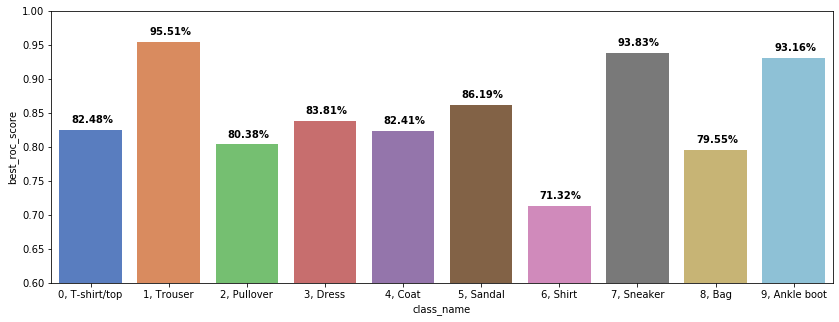

In [62]:
# plot all the results
fig, ax = plt.subplots(figsize=(14,5))
sns.barplot(x='class_name', y='best_roc_score', data=df2,palette="muted", ax=ax)
plt.ylim(0.6, 1.0)

# add value labels onto bar, from stackoverflow: http://bit.ly/2OH42fV
for i, v in enumerate(df2['best_roc_score']):
    ax.text(i-0.25, v+.01, "{:.2%}".format(v), color='black', fontweight='bold')

plt.show()